# Main Notebook

### Options

In [100]:
USING_THUMBNAILS = True
RAND = 1234 # for reproducabilty

### Imports

In [101]:
# CSV handling
import pandas as pd

# Data split
from sklearn.model_selection import train_test_split

# Image Processing
from PIL import Image

# Model building
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Visualization Tools
import matplotlib.pyplot as plt

# Misc
import numpy as np

Step 1: Read the CSV File

In [102]:
# Load the CSV file
data_csv = pd.read_csv("data/train.csv")

# Add image_path column
if not USING_THUMBNAILS:
    data_csv["image_path"] = data_csv["image_id"].apply(lambda x: f"data/train_thumbnails/{x}.png")
else:
    data_csv["image_path"] = data_csv["image_id"].apply(lambda x: f"data/train_thumbnails/{x}_thumbnail.png")
    # remove is_tma stuff as it is not in thumbnails
    data_csv = data_csv[data_csv['is_tma'] != True]

Encoding data

In [103]:
label_encoder = LabelEncoder()

# multiclass 
data_csv["encoded_label"] = label_encoder.fit_transform(data_csv["label"])

# binary (for each type)
for class_name in label_encoder.classes_:
    data_csv[f"label_{class_name}"] = (data_csv["label"] == class_name).astype(int)

Step 2: Split Data

In [104]:
train_df, val_df = train_test_split(data_csv, test_size=0.2, random_state=RAND)

Step 3: Preprocess Images

In [105]:
def resize_and_pad(img_path, target_size=(512, 512)):
    image = Image.open(img_path)

    # Calculate the ratio of the target dimensions to the original dimensions
    ratio = min(target_size[0] / image.size[0], target_size[1] / image.size[1])
    new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))

    # Resize the image
    resized_image = image.resize(new_size)

    # Create a new image with the desired size and black background
    new_image = Image.new("RGB", target_size)

    # Calculate coordinates to paste the resized image onto the center of the new image
    upper = (target_size[1] - new_size[1]) // 2
    left = (target_size[0] - new_size[0]) // 2
    new_image.paste(resized_image, (left, upper))

    return new_image

In [106]:
load_img = tf.keras.preprocessing.image.load_img
img_to_array = tf.keras.preprocessing.image.img_to_array

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def preprocess_img(img_path):
    img = resize_and_pad(img_path)
    img = img_to_array(img)

    # preprocess by model needs
    preprocess_input(img)

    return img

Step 4: Data Generator

(some form of bootstrapping)

In [107]:
to_categorical = tf.keras.utils.to_categorical

def data_generator(df, label_col, batch_size, num_classes=None, is_binary=False):
    while True:
        # Shuffle data in each epoch
        df: pd.DataFrame = df.sample(frac=1).reset_index(drop=True)

        for i in range(0 , len(df), batch_size):
            batch_df = df[i : i + batch_size]

            batch_imgs = np.array([preprocess_img(path) for path in batch_df["image_path"]])

            if is_binary:
                batch_labels = np.array(batch_df[label_col])
            else:
                batch_labels = to_categorical(batch_df[label_col], num_classes=num_classes)
            
            yield batch_imgs, batch_labels
    

def validation_data_generator(df, label_column, batch_size, num_classes=None, is_binary=False):
    while True:
        # DO NOT shuffle
        for i in range(0, len(df), batch_size):
            batch_df = df[i:i+batch_size]

            batch_images = np.array([preprocess_img(path) for path in batch_df['image_path']])
            
            if is_binary:
                batch_labels = np.array(batch_df[label_column])
            else:
                batch_labels = to_categorical(batch_df[label_column], num_classes=num_classes)

            yield batch_images, batch_labels


Create the model

In [108]:
layers = tf.keras.layers
models = tf.keras.models

In [109]:
base_model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet", # may be changed later
    input_shape=(512, 512, 3)
)
base_model.trainable = False # freeze base model

In [110]:
# multi class model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)  # 5 classes
model_multi = models.Model(inputs=base_model.input, outputs=output)

In [111]:
def create_binary_model(base_model):
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model_binary = models.Model(inputs=base_model.input, outputs=output)
    return model_binary

In [112]:
model_binary_hgsc = create_binary_model(base_model)
model_binary_lgsc = create_binary_model(base_model)
model_binary_cc = create_binary_model(base_model)
model_binary_ec = create_binary_model(base_model)
model_binary_mc = create_binary_model(base_model)

In [113]:
model_multi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_binary_hgsc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_binary_lgsc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_binary_cc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_binary_ec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_binary_mc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train Models

In [114]:
num_classes = 5
batch_size = 16
# multi model
train_gen_multi = data_generator(train_df, "encoded_label", batch_size, num_classes=num_classes)

# binary models
train_gen_hgsc = data_generator(train_df, 'label_HGSC', batch_size, is_binary=True)
train_gen_lgsc = data_generator(train_df, 'label_LGSC', batch_size, is_binary=True)
train_gen_cc = data_generator(train_df, 'label_CC', batch_size, is_binary=True)
train_gen_ec = data_generator(train_df, 'label_EC', batch_size, is_binary=True)
train_gen_mc = data_generator(train_df, 'label_MC', batch_size, is_binary=True)

# validation stuff
val_gen_multi = validation_data_generator(val_df, 'encoded_label', batch_size, num_classes=num_classes)

val_gen_hgsc = validation_data_generator(val_df, 'label_HGSC', batch_size, is_binary=True)
val_gen_lgsc = validation_data_generator(val_df, 'label_LGSC', batch_size, is_binary=True)
val_gen_cc = validation_data_generator(val_df, 'label_CC', batch_size, is_binary=True)
val_gen_ec = validation_data_generator(val_df, 'label_EC', batch_size, is_binary=True)
val_gen_mc = validation_data_generator(val_df, 'label_MC', batch_size, is_binary=True)


In [116]:
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
EarlyStopping = tf.keras.callbacks.EarlyStopping

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

histories = []

models = [model_multi, model_binary_hgsc, model_binary_lgsc, model_binary_cc, model_binary_ec, model_binary_mc]  # List of your models
generators = [train_gen_multi, train_gen_hgsc, train_gen_lgsc, train_gen_cc, train_gen_ec, train_gen_mc]  # Corresponding generators
val_gen = [val_gen_multi, val_gen_hgsc, val_gen_lgsc, val_gen_cc, val_gen_ec, val_gen_mc]

for model, generator, val_generator in zip(models, generators, val_gen):
    #print(model, generator, val_generator)
    # the callbacks
    # callbacks = [
    #     EarlyStopping(monitor='val_loss', patience=10),
    #     ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
    # ]

    h = model.fit(generator, epochs=3, validation_data=val_generator,
                  steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
    histories.append(h)



Epoch 1/3
25/25 [==============================] - 219s 9s/step - loss: 1.1512 - accuracy: 0.5381 - val_loss: 1.1978 - val_accuracy: 0.5000
Epoch 2/3
25/25 [==============================] - 217s 9s/step - loss: 1.0244 - accuracy: 0.5964 - val_loss: 1.3120 - val_accuracy: 0.4375
Epoch 3/3
25/25 [==============================] - 217s 9s/step - loss: 0.8602 - accuracy: 0.6650 - val_loss: 1.2375 - val_accuracy: 0.5000
Epoch 1/3
25/25 [==============================] - 247s 9s/step - loss: 0.8751 - accuracy: 0.5175 - val_loss: 0.6872 - val_accuracy: 0.5729
Epoch 2/3
25/25 [==============================] - 220s 9s/step - loss: 0.6110 - accuracy: 0.6624 - val_loss: 0.7118 - val_accuracy: 0.5417
Epoch 3/3
25/25 [==============================] - 218s 9s/step - loss: 0.5921 - accuracy: 0.6827 - val_loss: 0.6724 - val_accuracy: 0.5521
Epoch 1/3
25/25 [==============================] - 249s 9s/step - loss: 0.5324 - accuracy: 0.8925 - val_loss: 0.2150 - val_accuracy: 0.9479
Epoch 2/3
25/25 [===

Final model

In [136]:
def final_prediction(input_image, model_multi, binary_models, label_encoder):
    # Preprocess the input image similarly to how it was done for training
    processed_image = preprocess_img(input_image)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension

    # Step 1: Make a preliminary decision with the multi-class classifier
    pred_multi = model_multi.predict(processed_image)
    preliminary_decision = np.argmax(pred_multi, axis=-1)
    preliminary_label = label_encoder.inverse_transform([preliminary_decision])[0]
    
    # Step 2: Confirm with the corresponding binary classifier
    model_binary = binary_models[preliminary_label]
    pred_binary = model_binary.predict(processed_image)
    confirmed = (pred_binary > 0.5).astype(int)  # Assuming a threshold of 0.5 for binary classification

    # Return the final label
    if confirmed:
        return preliminary_label
    else:
        return 'Other'

# Map each label to its corresponding binary model
binary_models = {
    'HGSC': model_binary_hgsc,
    'LGSC': model_binary_lgsc,
    'CC' : model_binary_cc,
    'EC' : model_binary_ec,
    'MC' : model_binary_mc
}

In [141]:
val_image_paths = val_df['image_path'].tolist() # List of validation image paths
val_true_labels = val_df['label'].tolist()  # Corresponding true labels
val_image_paths = val_image_paths
val_true_labels = val_true_labels

In [139]:
def evaluate_on_validation_data(image_paths, true_labels, model_multi, binary_models, label_encoder):
    correct_predictions = 0

    for img_path, true_label in zip(image_paths, true_labels):
        predicted_label = final_prediction(img_path, model_multi, binary_models, label_encoder)

        if predicted_label == true_label:
            correct_predictions += 1
    accuracy = correct_predictions / len(image_paths)
    return accuracy

In [142]:
validation_accuracy = evaluate_on_validation_data(val_image_paths, val_true_labels, model_multi, binary_models, label_encoder)
print("Validation Accuracy:", validation_accuracy)

1/1 [==============================] - 0s 482ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 470ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 468ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 474ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 455ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 550ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 466ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 475ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 577ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 553ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 494ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 471ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 538ms/step
[3]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 458ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 453ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 468ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 480ms/step
[4]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 458ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 469ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 436ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 560ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 455ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 451ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 496ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 486ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 451ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 454ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 457ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 486ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 457ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 440ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 469ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 475ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 475ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 457ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 450ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 449ms/step
[4]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 487ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 469ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 534ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 449ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 482ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 461ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 517ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 466ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 460ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 452ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 470ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 465ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 452ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 482ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 516ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 437ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 469ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 466ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[3]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 451ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 484ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 462ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 451ms/step
[4]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 447ms/step
[4]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 434ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 484ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 477ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 450ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 517ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 534ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 550ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 501ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 502ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 501ms/step
[0]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 480ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 471ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 458ms/step
[3]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 472ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 527ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 488ms/step
[4]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 467ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 460ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 500ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 518ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 517ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 569ms/step
[3]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 510ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 475ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 504ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 466ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 524ms/step
[3]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 538ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 482ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 462ms/step
[2]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 1s 550ms/step
[1]
lol


c:\Users\Jerry Chen\.conda\envs\ubc-ocean\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 483ms/step
Validation Accuracy: 0.3786407766990291


Visualization stuff

[<keras.callbacks.History object at 0x00000135435954E0>, <keras.callbacks.History object at 0x00000136986A7BB0>, <keras.callbacks.History object at 0x00000135090181F0>, <keras.callbacks.History object at 0x00000136A3FDC2E0>, <keras.callbacks.History object at 0x00000136999F69E0>, <keras.callbacks.History object at 0x000001371EBB69E0>]


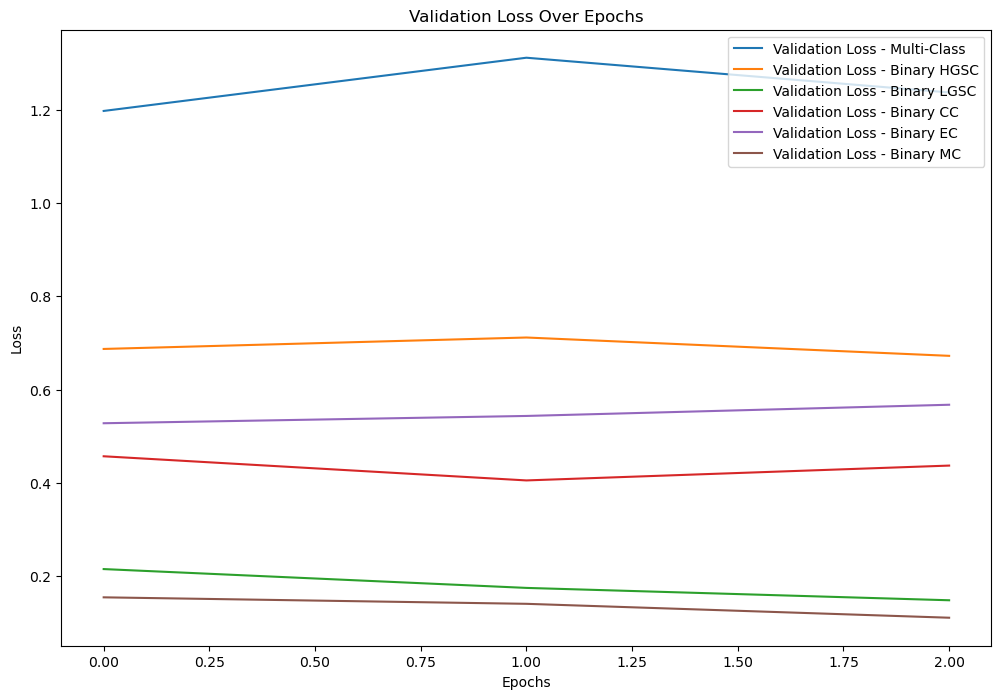

In [118]:
def plot_validation_error(histories, model_names):
    plt.figure(figsize=(12, 8))

    for history, name in zip(histories, model_names):
        val_loss = history.history['val_loss']
        plt.plot(val_loss, label=f'Validation Loss - {name}')

    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_validation_error(histories, ['Multi-Class', 'Binary HGSC', 'Binary LGSC', 'Binary CC', 'Binary EC', 'Binary MC'])

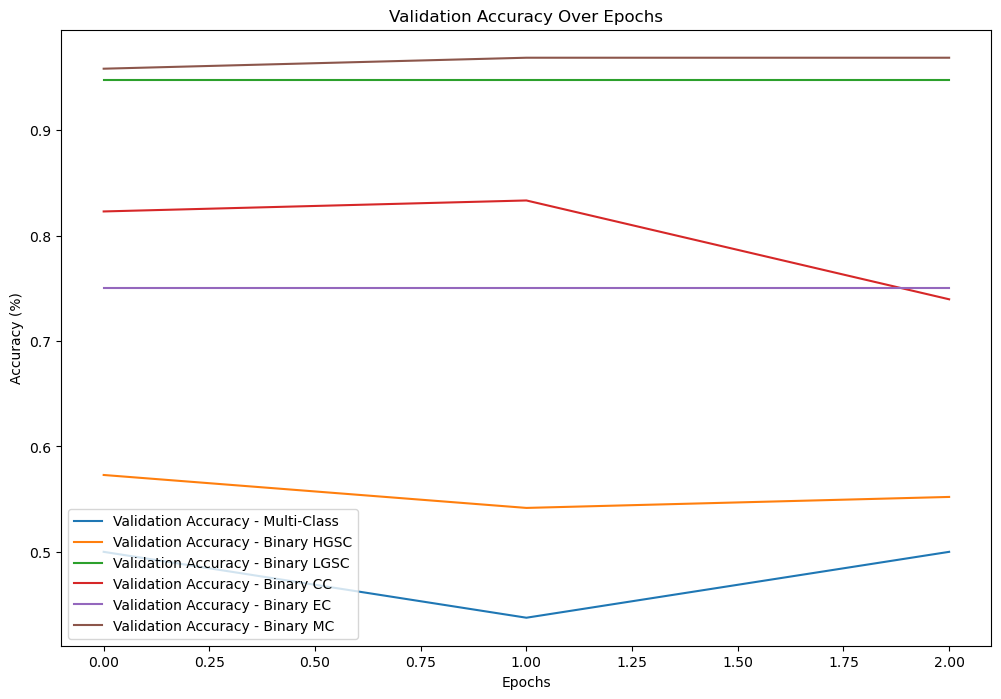

In [121]:
def plot_validation_acc(histories, model_names):
    plt.figure(figsize=(12, 8))

    for history, name in zip(histories, model_names):
        val_loss = history.history['val_accuracy']
        plt.plot(val_loss, label=f'Validation Accuracy - {name}')

    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_validation_acc(histories, ['Multi-Class', 'Binary HGSC', 'Binary LGSC', 'Binary CC', 'Binary EC', 'Binary MC'])

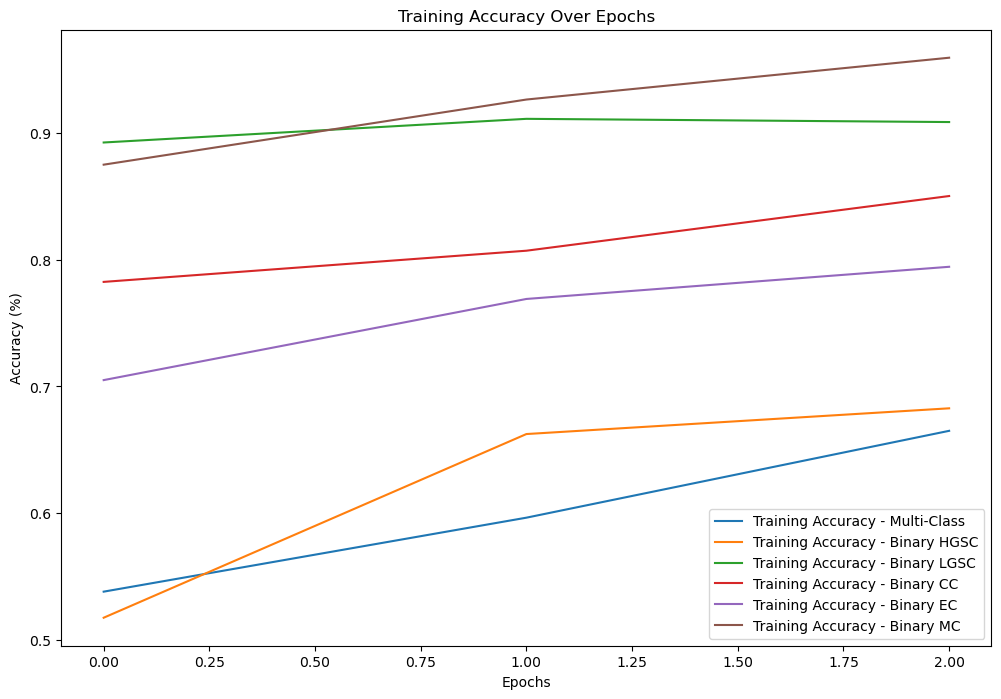

In [122]:
def plot_training_acc(histories, model_names):
    plt.figure(figsize=(12, 8))

    for history, name in zip(histories, model_names):
        val_loss = history.history['accuracy']
        plt.plot(val_loss, label=f'Training Accuracy - {name}')

    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_training_acc(histories, ['Multi-Class', 'Binary HGSC', 'Binary LGSC', 'Binary CC', 'Binary EC', 'Binary MC'])